<a href="https://colab.research.google.com/github/ntngann/UEL-RFM-Model/blob/RFM-model/Customer_segmentation_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import required libraries for dataframe and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from scipy.stats import kurtosis
from scipy.stats import skew

from scipy.stats import boxcox


# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

!pip install squarify
# libraries
import matplotlib.pyplot as plt
import squarify  # pip install squarify (algorithm for treemap)
import pandas as pd


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def plot_Boxplot(features_set, df):
    plt.rcParams['figure.figsize'] = [10,8]
    sns.boxplot(data = df[features_set], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
    plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel("Attributes", fontweight = 'bold')
    plt.show

def plot_His(features, df):
    plt.rcParams["figure.figsize"] = (20,5)
    fig, axs = plt.subplots(1, 3)
    cnt = 0
    for i in range(3):
        axs[i].hist(df[features[cnt]])
        axs[i].set_title('distribution of '+ features[cnt])
        cnt +=1


# First looks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Fundamentals of DA/FINAL/Source-code/Dataset/rfm_raw.csv')

In [ ]:
df.head()

,Unnamed: 0,CustomerID,R,F,M
0,0,11000,271,3,8248.99
1,1,11001,50,3,6383.88
2,2,11002,340,3,8114.04
3,3,11003,264,2,4739.30
4,4,11004,273,3,8196.01


In [ ]:
df = df.drop(columns="Unnamed: 0")
# df.rename(columns={'Recency': 'R', 'Frequency': 'F', 'Monetary':'M'}, inplace=True)
df.head()

,CustomerID,R,F,M
0,11000,271,3,8248.99
1,11001,50,3,6383.88
2,11002,340,3,8114.04
3,11003,264,2,4739.30
4,11004,273,3,8196.01


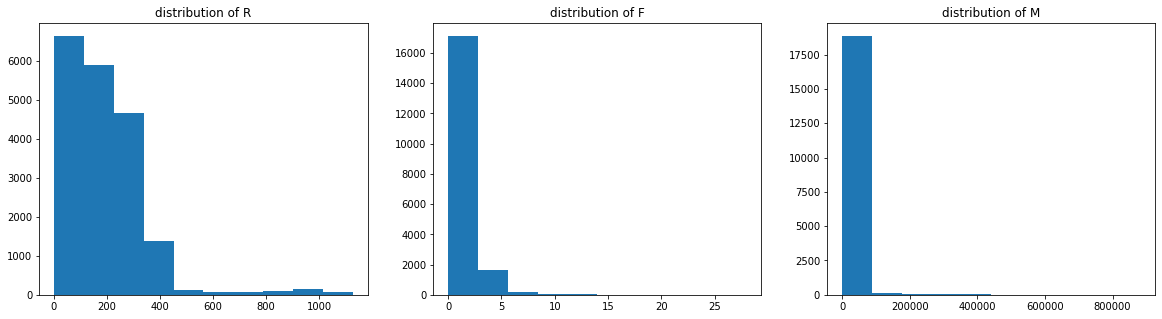

In [ ]:
features = ['R', 'F', 'M']
plot_His(features, df)


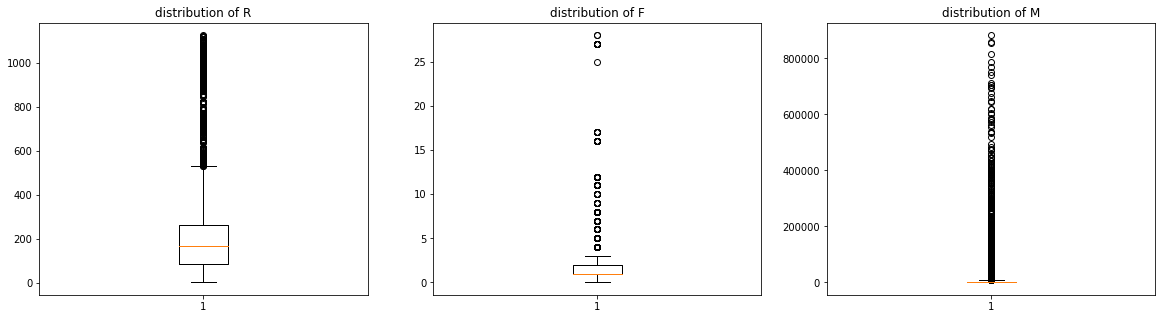

In [ ]:
fig, axs = plt.subplots(1, 3)
cnt = 0
for i in range(3):
        axs[i].boxplot(df[features[cnt]])
        axs[i].set_title('distribution of '+ features[cnt])
        cnt +=1
plt.show()

In [ ]:
df[['R','F','M']].agg(['skew','kurtosis'])

,R,F,M
skew,2.435350,7.426861,12.752155
kurtosis,9.990896,91.174787,192.127125


The above features do not allow normalized distribution => dataset of each feature is postitive skewed, long tails

*   If the skewness is between -0.5 & 0.5, the data are nearly symmetrical.
*   If the skewness is between -1 & -0.5 (negative skewed) or between 0.5 & 1(positive skewed), the data are slightly skewed.
*If the skewness is lower than -1 (negative skewed) or greater than 1 (positive skewed), the data are extremely skewed.

**=> R, F, M are extremmely skewed (right skewed)**



*   Leptokurtic or heavy-tailed distribution (kurtosis more than normal distribution). >3
*   Mesokurtic (kurtosis same as the normal distribution). =3
* Platykurtic or short-tailed distribution (kurtosis less than normal distribution). <3

**=> Have to remove ouliers and transform these features to follow normal distribution**



# Data preparation

## Outliers detection

In [ ]:
df_check = df[features].copy()
df_check.head()

,R,F,M
0,271,3,8248.99
1,50,3,6383.88
2,340,3,8114.04
3,264,2,4739.30
4,273,3,8196.01


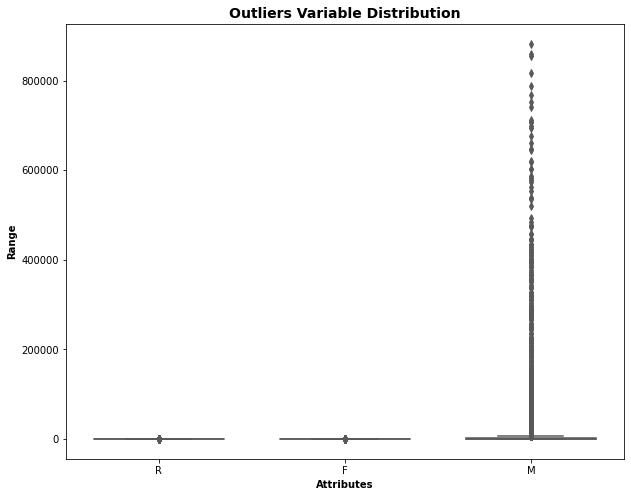

In [ ]:
# Outlier Analysis of Amount Frequency and Recency
plot_Boxplot(features, df_check)

In [ ]:
# Removing (statistical) outliers for Amount
Q1 = df_check.M.quantile(0.05)
Q3 = df_check.M.quantile(0.95)
IQR = Q3 - Q1
df_check = df_check[(df_check.M >= Q1 - 1.5*IQR) & (df_check.M <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = df_check.R.quantile(0.05)
Q3 = df_check.R.quantile(0.95)
IQR = Q3 - Q1
df_check = df_check[(df_check.R >= Q1 - 1.5*IQR) & (df_check.R <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = df_check.F.quantile(0.05)
Q3 = df_check.F.quantile(0.95)
IQR = Q3 - Q1
df_check = df_check[(df_check.F >= Q1 - 1.5*IQR) & (df_check.F <= Q3 + 1.5*IQR)]

In [ ]:
# check skew kurtosis again
df_check[['R','F','M']].agg(['skew','kurtosis'])

,R,F,M
skew,0.934077,1.738240,1.536461
kurtosis,2.047351,4.059411,2.106437


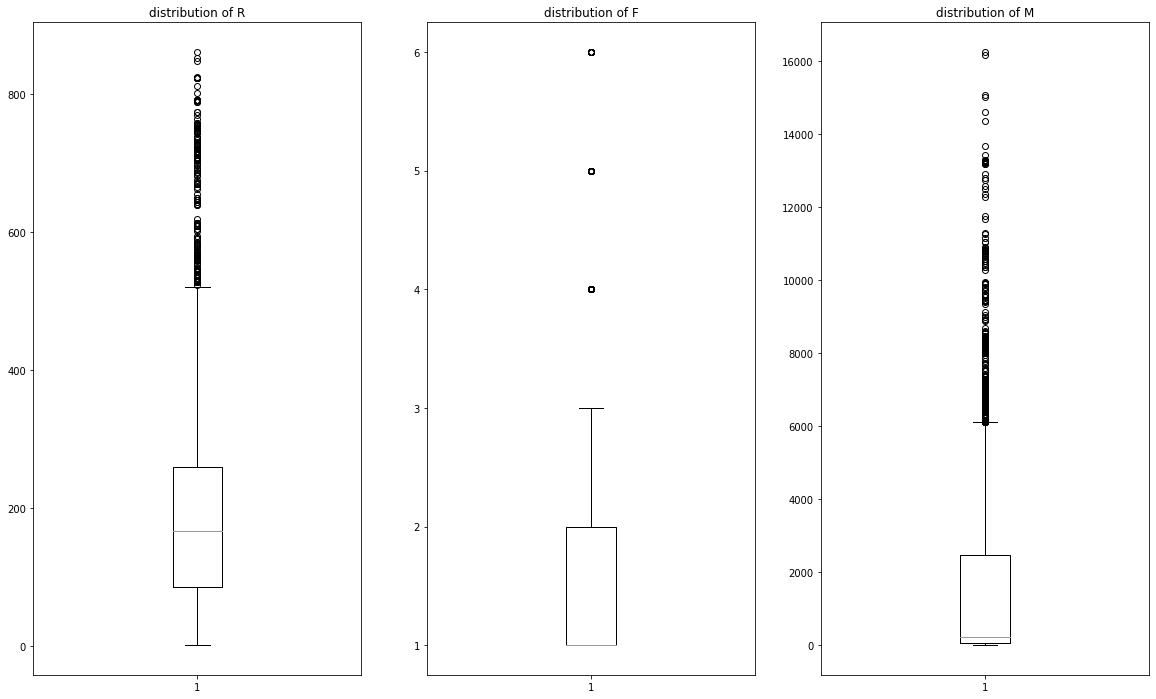

In [ ]:
plt.rcParams['figure.figsize'] = [20,12]
fig, axs = plt.subplots(1, 3)
cnt = 0
for i in range(3):
        axs[i].boxplot(df_check[features[cnt]])
        axs[i].set_title('distribution of '+ features[cnt])
        cnt +=1
plt.show()

##Data transformation
* SQRT
* Cube root
* Box Cox 
* Log transformation

In [ ]:
df_check.head()

,R,F,M
0,271,3,8248.99
1,50,3,6383.88
2,340,3,8114.04
3,264,2,4739.30
4,273,3,8196.01


###Square root transformation

In [ ]:
#SQRT transformation
df_check.insert(len(df_check.columns), 'sqrt_R', np.sqrt(df_check['R']))
df_check.insert(len(df_check.columns), 'sqrt_F', np.sqrt(df_check['F']))
df_check.insert(len(df_check.columns), 'sqrt_M', np.sqrt(df_check['M']))

###Cube root transformation

In [ ]:
#cube root transformation
df_check['cubr_R']= np.cbrt(df['R'])
df_check['cubr_F']= np.cbrt(df['F'])
df_check['cubr_M']= np.cbrt(df['M'])

### Standard scale data



*   https://www.atoti.io/when-to-perform-a-feature-scaling/
*   https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/



In [ ]:
# Rescaling the attributes
# Instantiate
scaler = StandardScaler()

# fit_transform
df_check['scaled_R'] = scaler.fit_transform(df_check[['R']])
df_check['scaled_F'] = scaler.fit_transform(df_check[['F']])
df_check['scaled_M'] = scaler.fit_transform(df_check[['M']])


### Log transformation

In [ ]:
# log transformation
df_check['log_R']= np.log(df_check['R'])
df_check['log_F']= np.log(df_check['F'])
df_check['log_M']= np.log(df_check['M'])

### Boxcox transformation

In [ ]:
# Box cox transformation
df_check['box_R']= boxcox(df_check['R'], 0)
df_check['box_F']= boxcox(df_check['F'], 0)
df_check['box_M']= boxcox(df_check['M'], 0)

In [ ]:
df_check.head()

,R,F,M,sqrt_R,sqrt_F,sqrt_M,cubr_R,cubr_F,cubr_M,scaled_R,scaled_F,scaled_M,log_R,log_F,log_M,box_R,box_F,box_M
0,271,3,8248.99,16.462078,1.732051,90.823951,6.471274,1.442250,20.205375,0.783557,2.106588,3.059860,5.602119,1.098612,9.017846,5.602119,1.098612,9.017846
1,50,3,6383.88,7.071068,1.732051,79.899186,3.684031,1.442250,18.550754,-1.131215,2.106588,2.202572,3.912023,1.098612,8.761531,3.912023,1.098612,8.761531
2,340,3,8114.04,18.439089,1.732051,90.077966,6.979532,1.442250,20.094585,1.381382,2.106588,2.997831,5.828946,1.098612,9.001351,5.828946,1.098612,9.001351
3,264,2,4739.30,16.248077,1.414214,68.842574,6.415069,1.259921,16.797245,0.722908,0.716794,1.446650,5.575949,0.693147,8.463645,5.575949,0.693147,8.463645
4,273,3,8196.01,16.522712,1.732051,90.531818,6.487154,1.442250,20.162026,0.800885,2.106588,3.035508,5.609472,1.098612,9.011403,5.609472,1.098612,9.011403


In [ ]:
df_check.agg(['skew','kurtosis']).transpose()

,skew,kurtosis
R,0.934077,2.047351
F,1.738240,4.059411
M,1.536461,2.106437
sqrt_R,-0.044529,-0.294214
sqrt_F,1.205965,0.975291
sqrt_M,0.726561,-0.785735
cubr_R,-0.390888,-0.091464
cubr_F,1.081797,0.379551
cubr_M,0.477237,-1.218065
scaled_R,0.934077,2.047351


In [ ]:
features_cube = ['cubr_R', 'cubr_F', 'cubr_M']
features_sqrt = ['sqrt_R', 'sqrt_F', 'sqrt_M']
features_log = ['log_R', 'log_F', 'log_M']
features_scaled = ['scaled_R', 'scaled_F', 'scaled_M']
features_box = ['box_R', 'box_F', 'box_M']

In [ ]:
df_check[features_scaled].head()

,scaled_R,scaled_F,scaled_M
0,0.783557,2.106588,3.059860
1,-1.131215,2.106588,2.202572
2,1.381382,2.106588,2.997831
3,0.722908,0.716794,1.446650
4,0.800885,2.106588,3.035508


# Building the Model

In [ ]:
df_scaled = df_check[features_scaled]

## K-Means



*    https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/
*   https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py



###Finding the Optimal Number of Clusters



***Elbow Curve to get the right number of Clusters***

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

In [ ]:
def makeElbowWithPlot(range_n_clusters, features, df):
    ssd = []
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
        kmeans.fit_predict(df_check[features])

        ssd.append(kmeans.inertia_)
        
    plt.plot(ssd)
    plt.xticks(np.arange(len(range_n_clusters)), range_n_clusters)
    plt.show()

    return ssd


def makeSilhouetteWithPlot(range_n_clusters, features, df):
    # Silhouette analysis
    sil_score = []
    for num_clusters in range_n_clusters:
        # intialise kmeans
        kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
        preds = kmeans.fit_predict(df_check[features])
        
        cluster_labels = kmeans.labels_
        
        # silhouette score
        silhouette_avg = silhouette_score(df_check[features], preds)
        sil_score.append(silhouette_avg)
        print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

    # plot the SSDs for each n_clusters
    plt.plot(sil_score)
    plt.xticks(np.arange(len(range_n_clusters) + 1), range_n_clusters)
    plt.show()

    return sil_score

**Silhouette Analysis**
silhouette_score=p−q/max(p,q)
 
p  is the mean distance to the points in the nearest cluster that the data point is not a part of

q  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

### Set of squared features

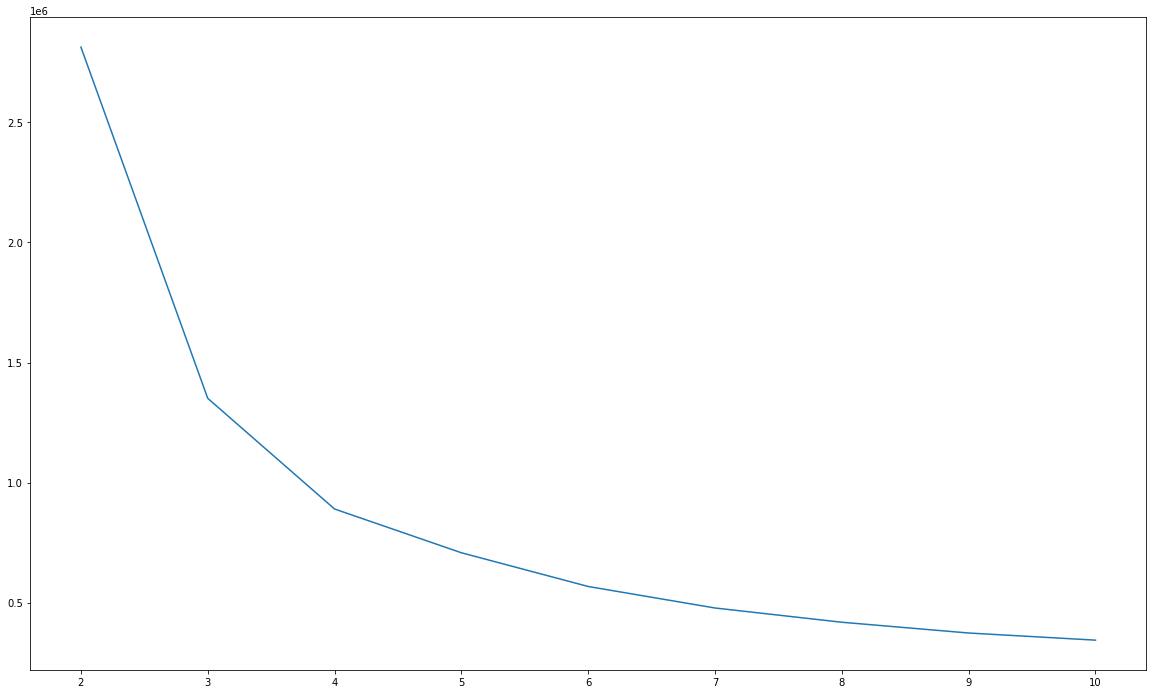

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
ssd_sqr = makeElbowWithPlot(range_n_clusters, features_sqrt, df_check)

For n_clusters=2, the silhouette score is 0.6874297583111196
For n_clusters=3, the silhouette score is 0.6475923890464902
For n_clusters=4, the silhouette score is 0.5984053448499229
For n_clusters=5, the silhouette score is 0.5742985921906565
For n_clusters=6, the silhouette score is 0.4477632715216215
For n_clusters=7, the silhouette score is 0.44529912161052676
For n_clusters=8, the silhouette score is 0.44728813217483465
For n_clusters=9, the silhouette score is 0.44528111936568415
For n_clusters=10, the silhouette score is 0.3990956607173526


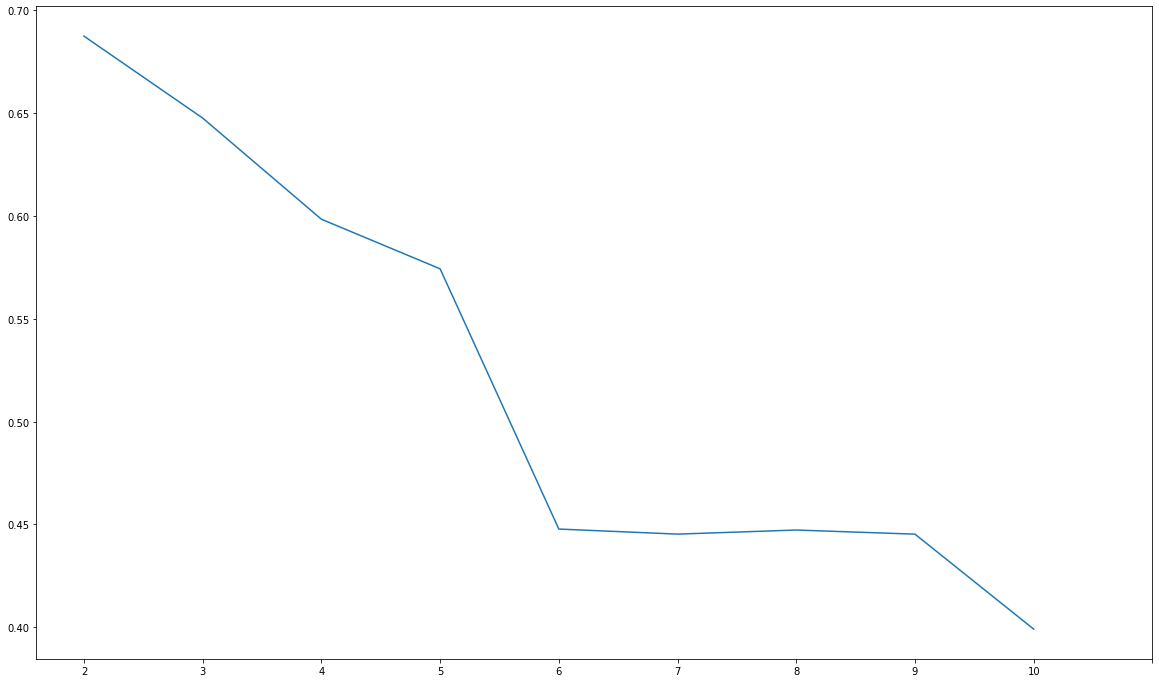

In [ ]:
sil_sc_sqr = makeSilhouetteWithPlot(range_n_clusters, features_sqrt, df_check)

The log graph present the optimal K is 2, but it's impossible

### Set of cubed features

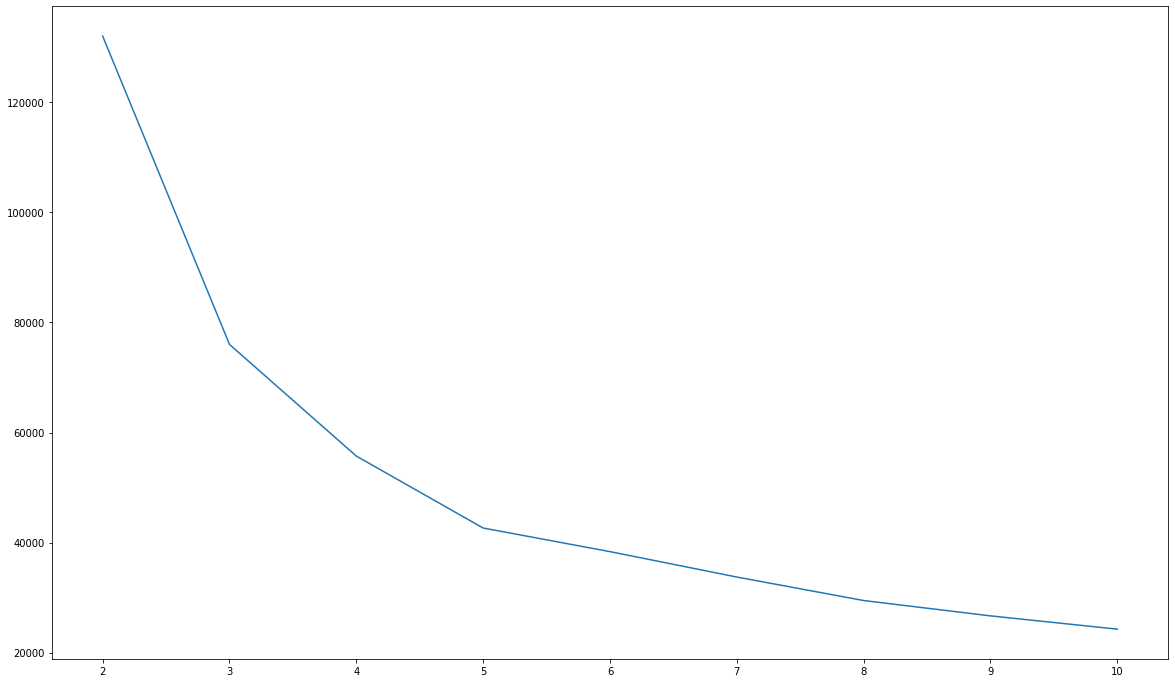

[132029.70296020032, 76012.56546042833, 55725.8083109986, 42652.931070456994, 38363.25959183344, 33747.486455003556, 29479.739130830676, 26689.77498908881, 24277.157178603622]


In [ ]:
ssd_cub = makeElbowWithPlot(range_n_clusters, features_cube, df_check)
print(ssd_cub)

For n_clusters=2, the silhouette score is 0.6714219880670315
For n_clusters=3, the silhouette score is 0.5861294958239455
For n_clusters=4, the silhouette score is 0.5445675874615856
For n_clusters=5, the silhouette score is 0.44186059554029206
For n_clusters=6, the silhouette score is 0.40061065956330555
For n_clusters=7, the silhouette score is 0.36066360366392197
For n_clusters=8, the silhouette score is 0.36786975129928673
For n_clusters=9, the silhouette score is 0.3650395315936556
For n_clusters=10, the silhouette score is 0.3620825006588858


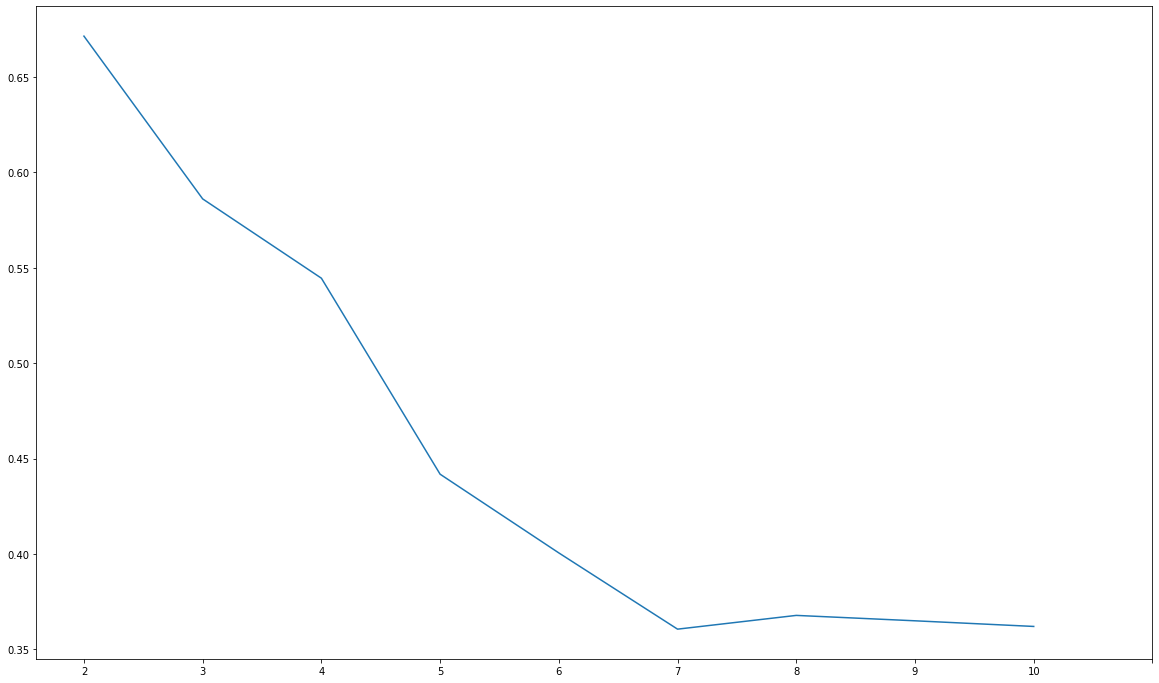

In [ ]:
sil_sc_cub = makeSilhouetteWithPlot(range_n_clusters, features_cube, df_check)

### Set of scaled features

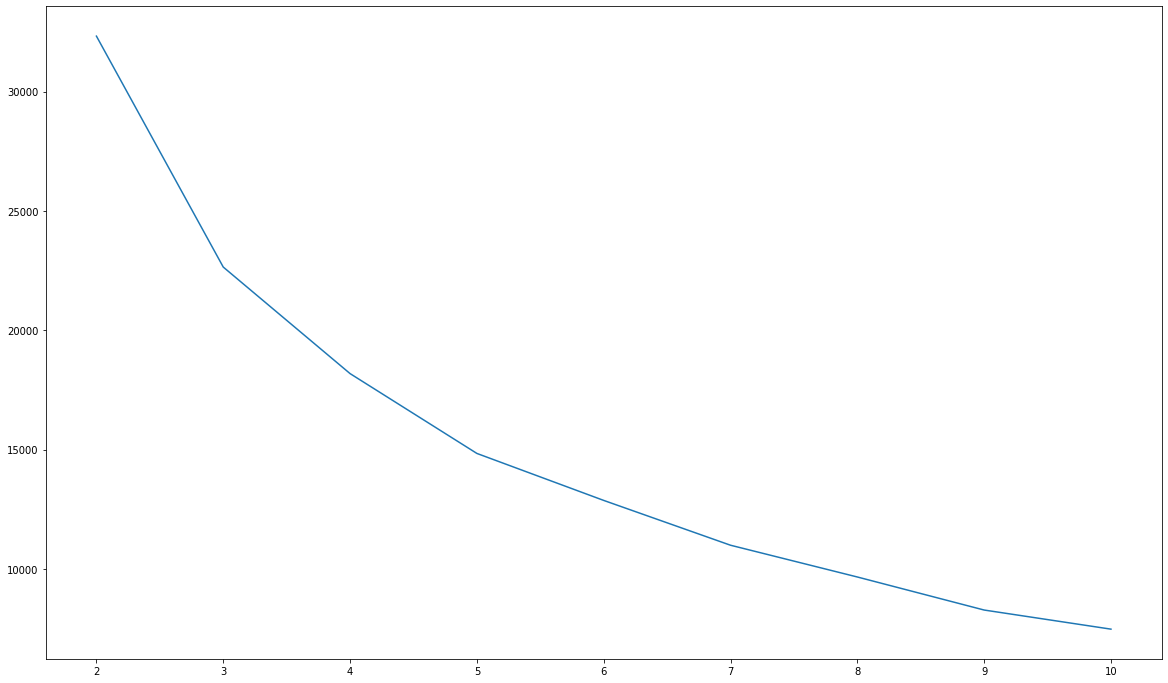

[32329.934329772193, 22651.49181624528, 18185.95522625697, 14839.882779834657, 12870.772446578942, 10992.476586692257, 9661.087856611139, 8276.097616578776, 7474.9852067334705]


In [ ]:
ssd_scaled = makeElbowWithPlot(range_n_clusters, features_scaled, df_check)
print(ssd_scaled)

For n_clusters=2, the silhouette score is 0.45722985138848066
For n_clusters=3, the silhouette score is 0.40571177924680507
For n_clusters=4, the silhouette score is 0.4193301516312188
For n_clusters=5, the silhouette score is 0.44670638765781073
For n_clusters=6, the silhouette score is 0.45130602483777477
For n_clusters=7, the silhouette score is 0.461528989801395
For n_clusters=8, the silhouette score is 0.4066269777931937
For n_clusters=9, the silhouette score is 0.4236516938054903
For n_clusters=10, the silhouette score is 0.4335105303418775


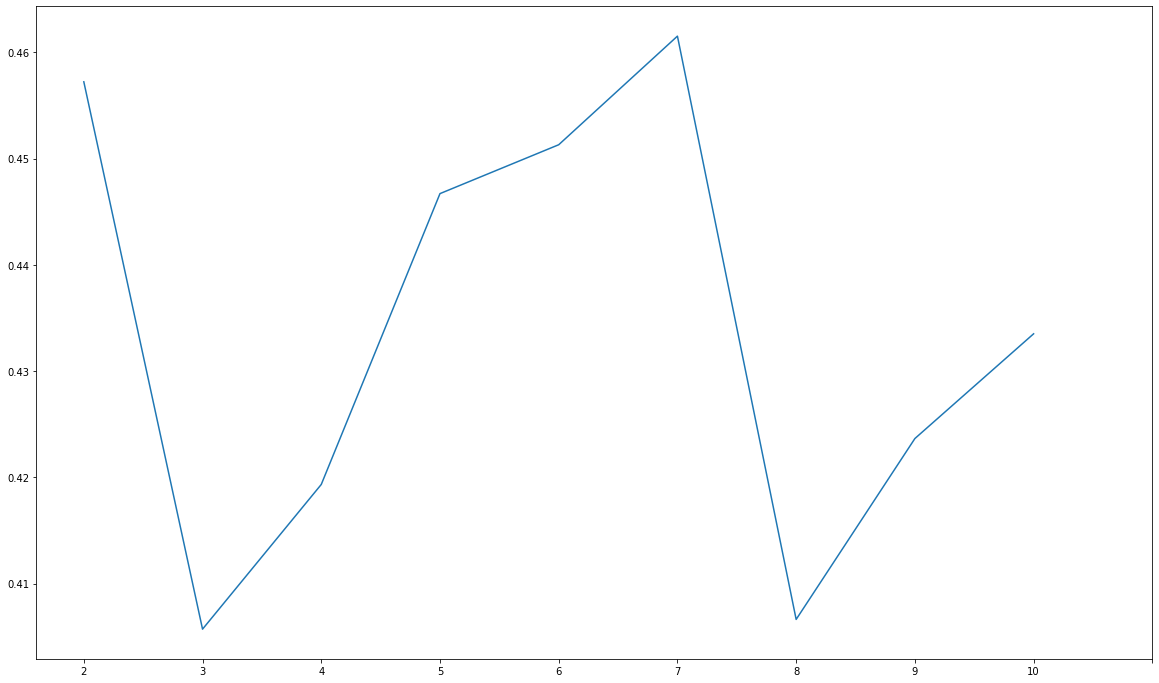

In [ ]:
sil_sc_scaled = makeSilhouetteWithPlot(range_n_clusters, features_scaled, df_check)

###**FINAL MODEL WITH K=7**

In [ ]:
rfm = df_check[features_scaled].copy()

# Final model with k=7
kmeans = KMeans(n_clusters=7, max_iter=50)
label = kmeans.fit_predict(rfm)

In [ ]:
# assign the label
df_check['Cluster_Id'] = kmeans.labels_
df_check[features_scaled + ['Cluster_Id']].head()

,scaled_R,scaled_F,scaled_M,Cluster_Id
0,0.783557,2.106588,3.059860,6
1,-1.131215,2.106588,2.202572,6
2,1.381382,2.106588,2.997831,6
3,0.722908,0.716794,1.446650,2
4,0.800885,2.106588,3.035508,6


In [ ]:
label

array([6, 6, 6, ..., 6, 6, 2], dtype=int32)

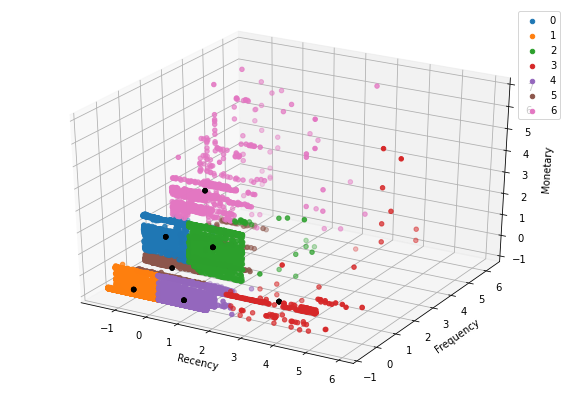

In [ ]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for i in u_labels:
    ax.scatter3D(rfm[label == i]['scaled_R'] , rfm[label == i]['scaled_F'] , rfm[label == i]['scaled_M'], label = i)
    ax.scatter3D(centroids[:,0] , centroids[:,1] , centroids[:,2], s = 20, color = 'k')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend()
plt.show()

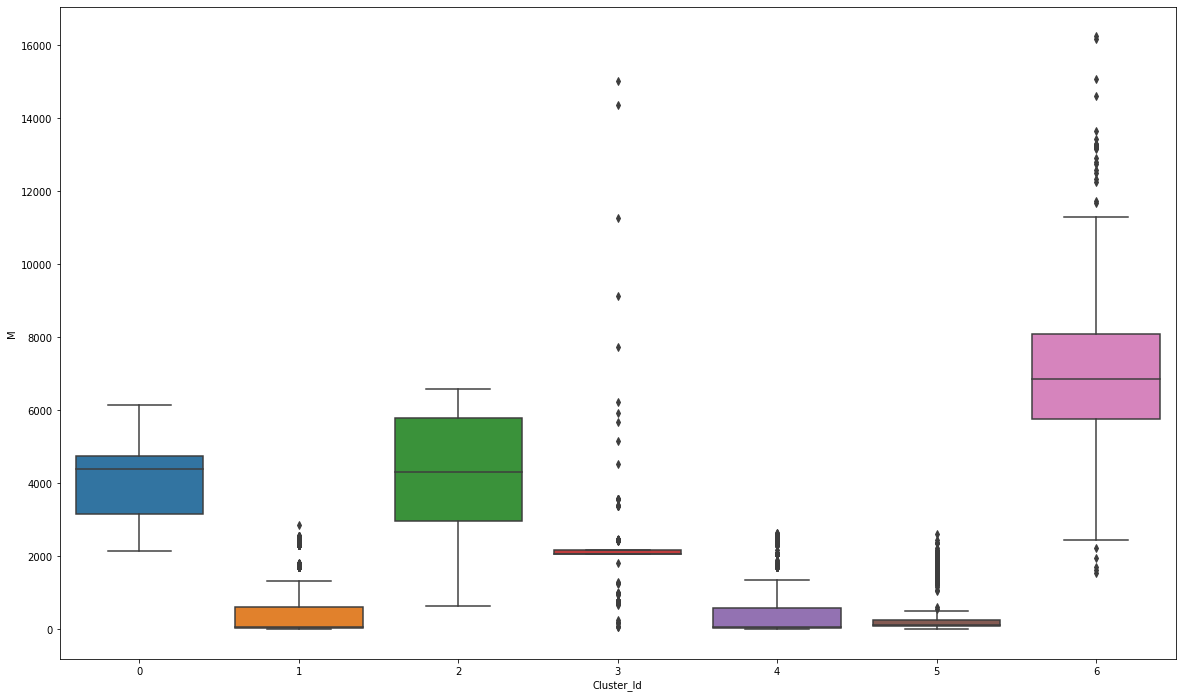

In [ ]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='M', data=df_check)

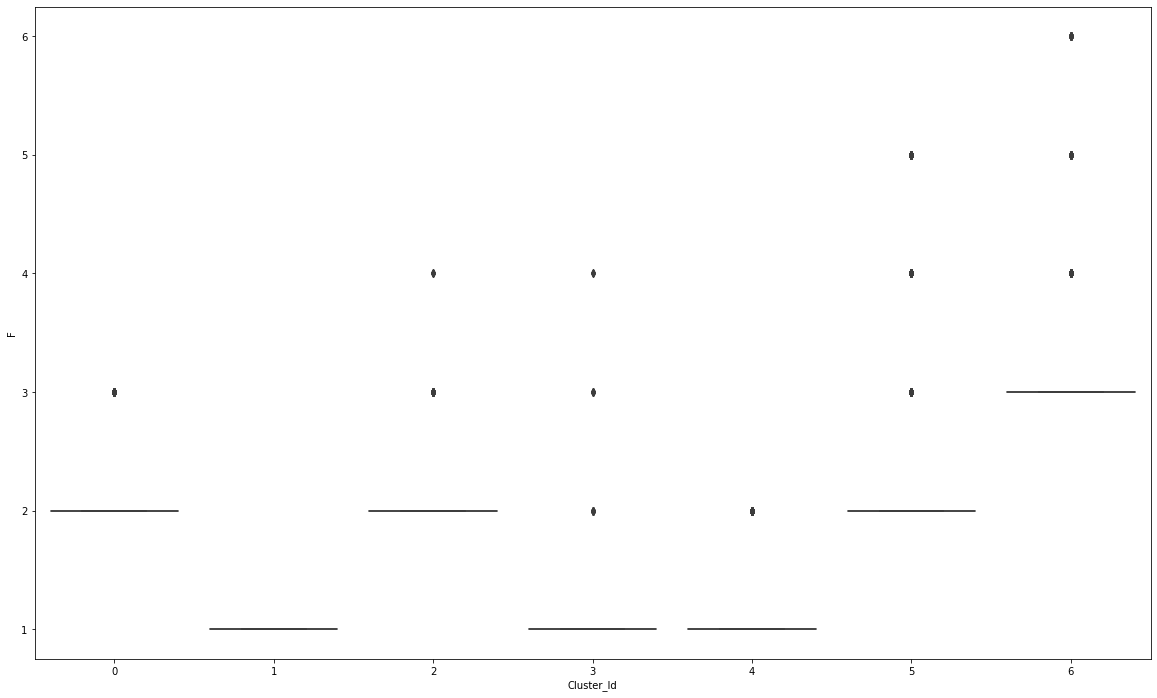

In [ ]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='F', data=df_check)

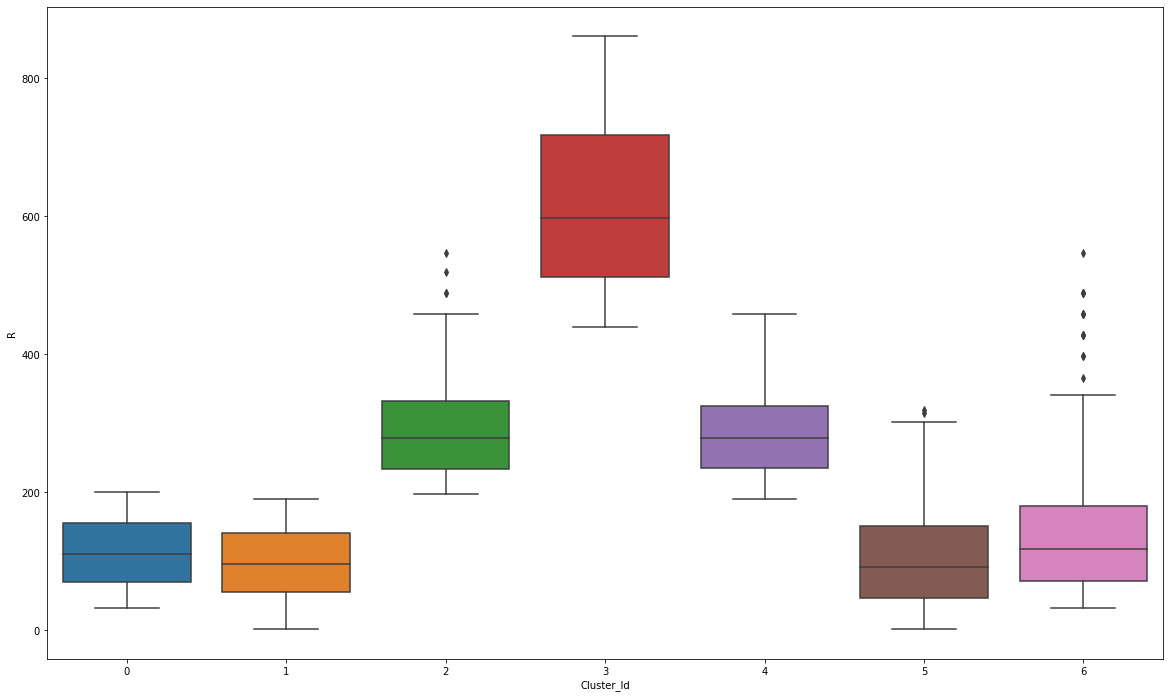

In [ ]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='R', data=df_check)

##Hierarchical Clustering

https://www.analyticsvidhya.com/blog/2021/06/single-link-hierarchical-clustering-clearly-explained/

###Single Linkage:

In [ ]:
plt.rcParams['figure.figsize'] = [20,10]

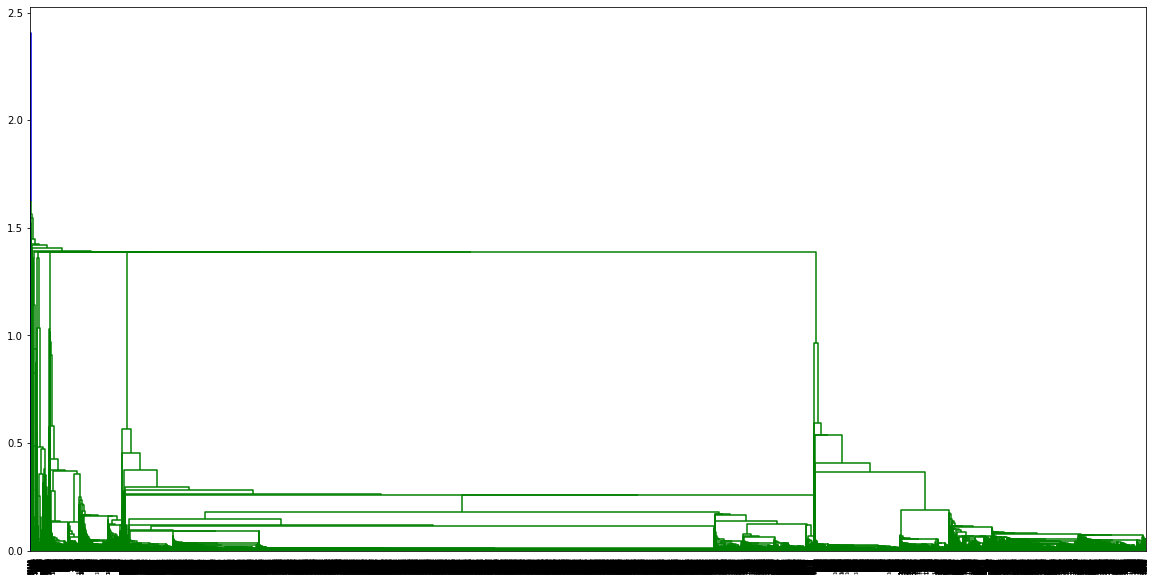

In [ ]:
mergings_single = linkage(df_check[features_scaled], method="single", metric='euclidean')
dendrogram(mergings_single)
plt.show()

###Complete Linkage:

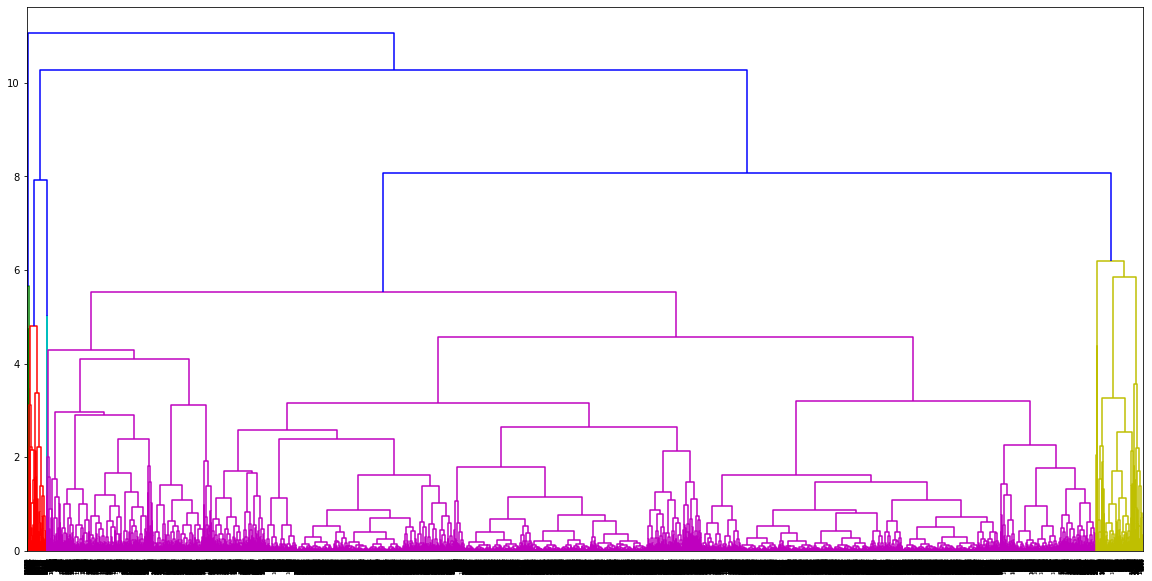

In [ ]:
mergings_complete = linkage(df_check[features_scaled], method="complete", metric='euclidean')
dendrogram(mergings_complete)
plt.show()

###Average Linkage:

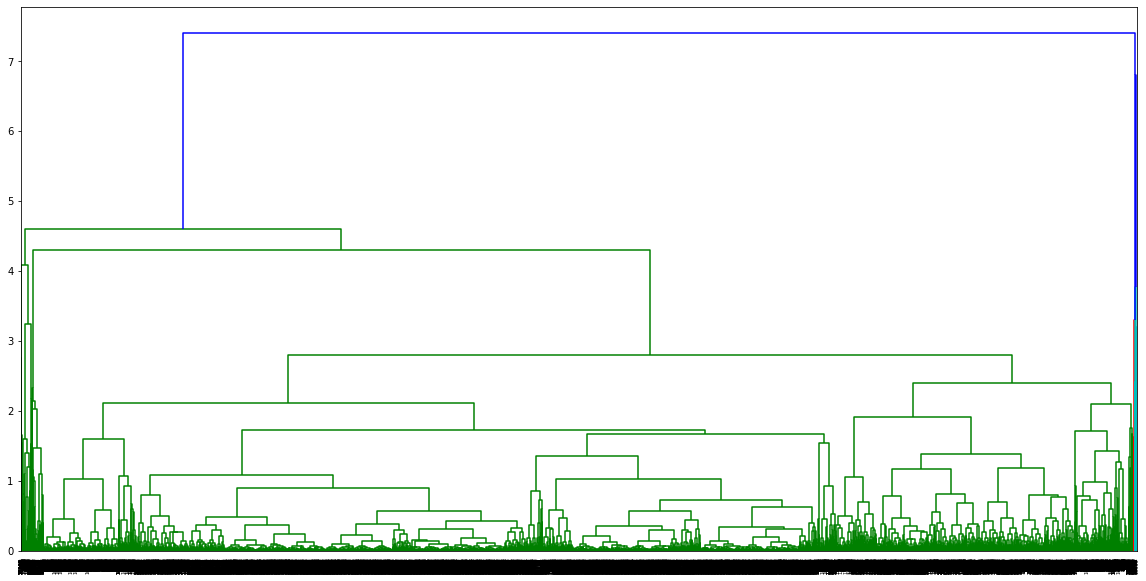

In [ ]:
mergings_avg = linkage(df_check[features_scaled], method="average", metric='euclidean')
dendrogram(mergings_avg)
plt.show()

### Cut off the tree



*   https://www.researchgate.net/post/How_to_decide_the_cut-off_point_of_a_dendrogram_for_clustering_analysis
*   https://stats.stackexchange.com/questions/3685/where-to-cut-a-dendrogram



In [ ]:
# 7 clusters
cluster_labels = cut_tree(mergings_complete, n_clusters=7).reshape(-1, 1)
cluster_labels

array([[0],
       [1],
       [0],
       ...,
       [1],
       [5],
       [5]])

In [ ]:
# Assign cluster labels

df_check['Cluster_Labels_hc'] = cluster_labels
df_check[features_scaled + ['Cluster_Labels_hc']].head()

,scaled_R,scaled_F,scaled_M,Cluster_Labels_hc
0,0.783557,2.106588,3.059860,0
1,-1.131215,2.106588,2.202572,1
2,1.381382,2.106588,2.997831,0
3,0.722908,0.716794,1.446650,0
4,0.800885,2.106588,3.035508,0


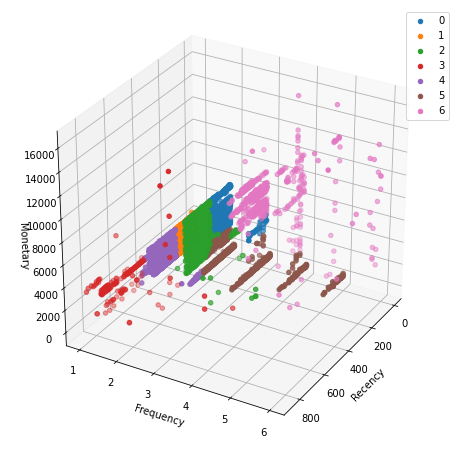

In [ ]:

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
  
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = '3d')
  
for i in u_labels:
  # Data for a three-dimensional line
  z = df_check[label == i][features[2]]
  x = df_check[label == i][features[0]]
  y = df_check[label == i][features[1]]
  ax.scatter3D(x, y, z, label=i)
  

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend()

ax.view_init(30, 30)
plt.show()

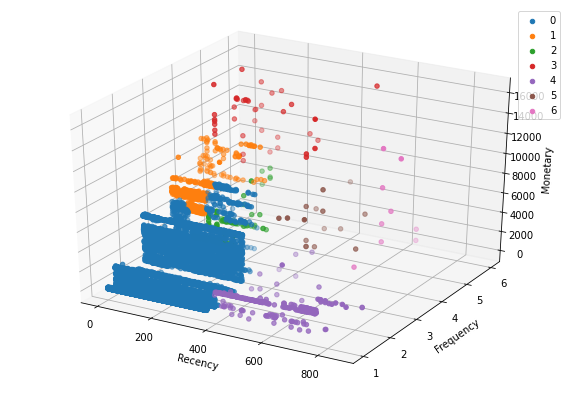

In [ ]:
label = cluster_labels
u_labels = np.unique(label)
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for i in u_labels:
    ax.scatter3D(df_check[label == i][features[0]] , df_check[label == i][features[1]] , df_check[label == i][features[2]], label = i)
    # ax.scatter3D(centroids[:,0] , centroids[:,1] , centroids[:,2], s = 20, color = 'k')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend()
plt.show()

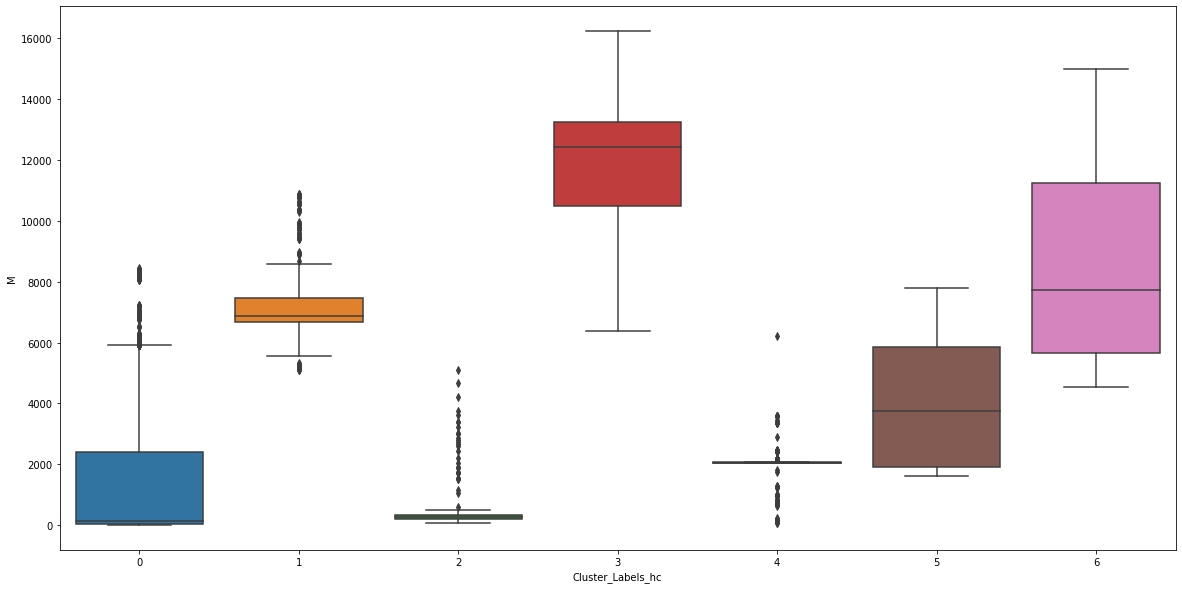

In [ ]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels_hc', y='M', data=df_check)

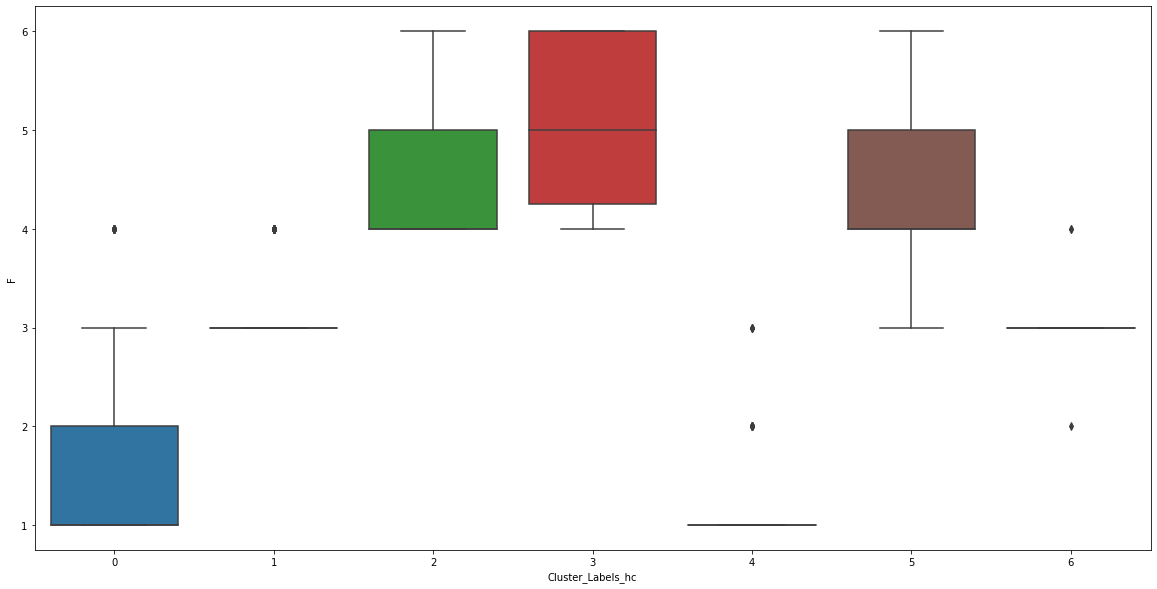

In [ ]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels_hc', y='F', data=df_check)

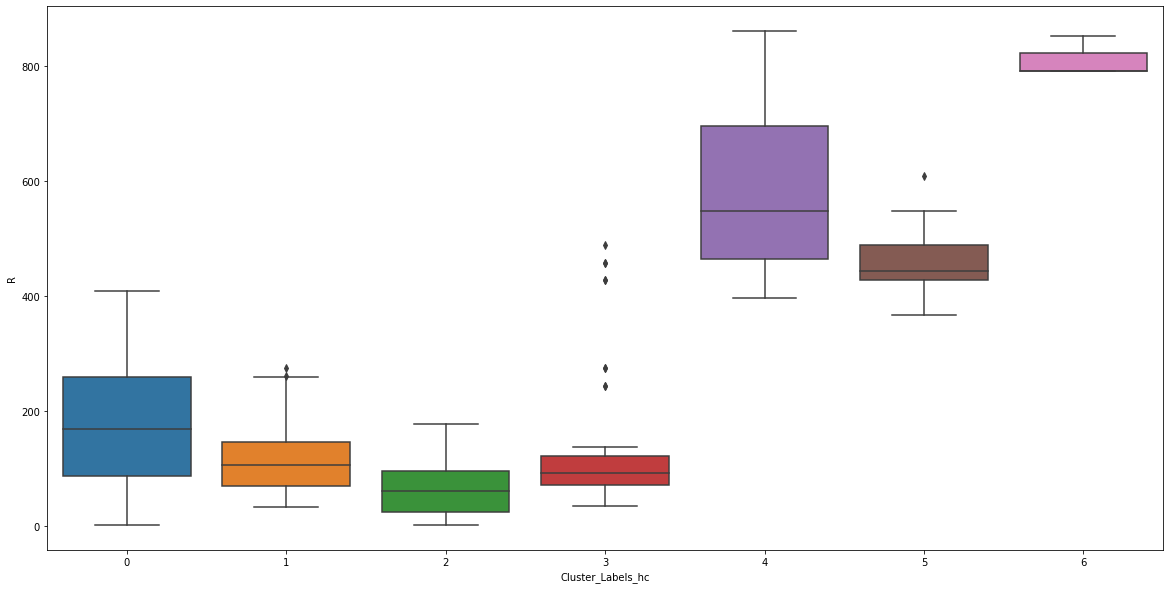

In [ ]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels_hc', y='R', data=df_check)

## Traditional RFM

In [ ]:
traditional_rfm = df_check[features]

In [ ]:
quantiles = traditional_rfm[['R', 'F', 'M']].quantile([.2, .4, .6, .8]).to_dict()
quantiles

{'F': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 2.0},
 'M': {0.2: 39.98, 0.4: 90.202, 0.6: 1155.48, 0.8: 3150.4262},
 'R': {0.2: 72.0, 0.4: 132.0, 0.6: 204.0, 0.8: 284.0}}

In [ ]:
def r_score(x):
    if x <= quantiles['R'][.2]:
        return 5
    elif x <= quantiles['R'][.4]:
        return 4
    elif x <= quantiles['R'][.6]:
        return 3
    elif x <= quantiles['R'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quantiles[c][.2]:
        return 1
    elif x <= quantiles[c][.4]:
        return 2
    elif x <= quantiles[c][.6]:
        return 3
    elif x <= quantiles[c][.8]:
        return 4
    else:
        return 5   

In [ ]:
traditional_rfm['R_score'] = traditional_rfm['R'].apply(lambda x: r_score(x))
traditional_rfm['F_score'] = traditional_rfm['F'].apply(lambda x: fm_score(x, 'F'))
traditional_rfm['M_score'] = traditional_rfm['M'].apply(lambda x: fm_score(x, 'M'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
traditional_rfm['RFM Score'] = traditional_rfm['R_score'].map(str) + traditional_rfm['F_score'].map(str) + traditional_rfm['M_score'].map(str)
traditional_rfm.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,R,F,M,R_score,F_score,M_score,RFM Score
0,271,3,8248.99,2,5,5,255
1,50,3,6383.88,5,5,5,555
2,340,3,8114.04,1,5,5,155
3,264,2,4739.30,2,4,5,245
4,273,3,8196.01,2,5,5,255


In [ ]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

traditional_rfm['Segment'] = traditional_rfm['R_score'].map(str) + traditional_rfm['F_score'].map(str)
traditional_rfm['Segment'] = traditional_rfm['Segment'].replace(segt_map, regex=True)
traditional_rfm.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,R,F,M,R_score,F_score,M_score,RFM Score,Segment
0,271,3,8248.99,2,5,5,255,can't loose
1,50,3,6383.88,5,5,5,555,champions
2,340,3,8114.04,1,5,5,155,can't loose
3,264,2,4739.30,2,4,5,245,at risk
4,273,3,8196.01,2,5,5,255,can't loose


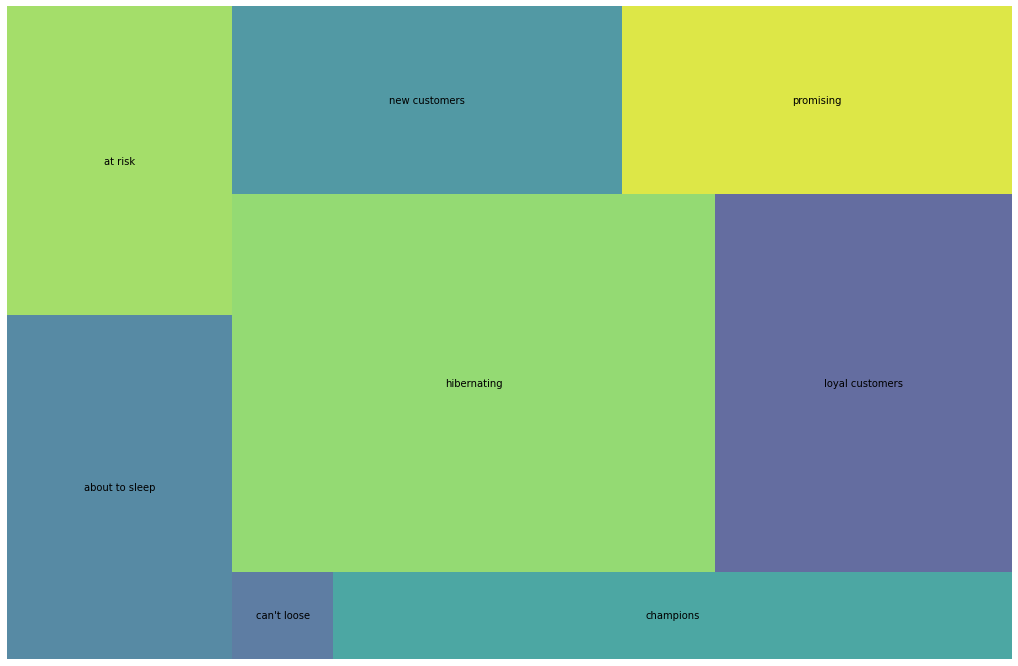

In [ ]:
results = traditional_rfm.groupby(['Segment']).count()[['RFM Score']]


plt.figure(figsize=(18, 12))

# plot it
squarify.plot(sizes=np.array(results['RFM Score'].values.tolist()), label=results.index, alpha=.8 )
plt.axis('off')
plt.show()

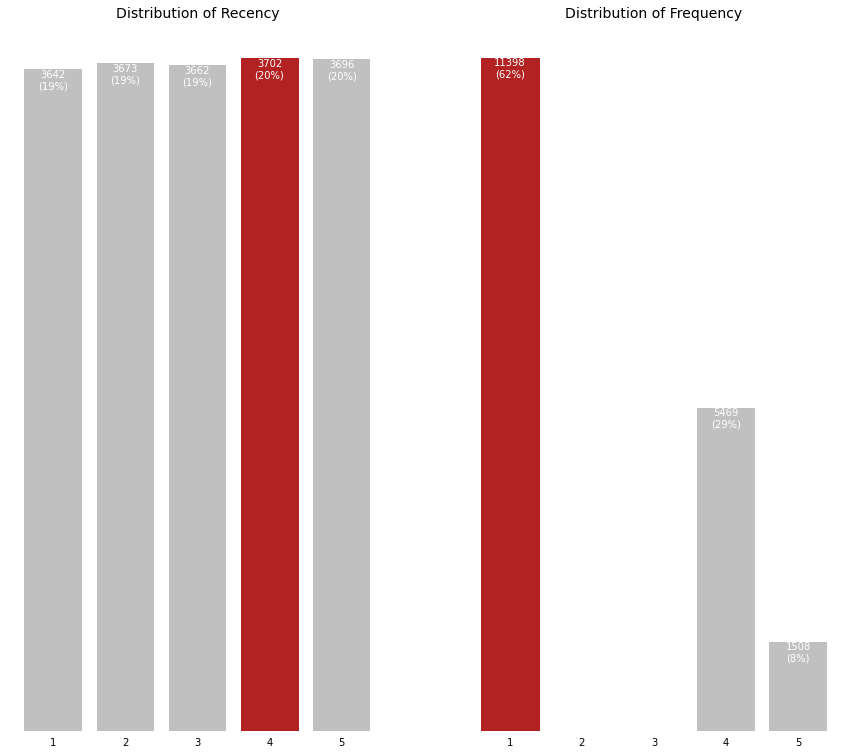

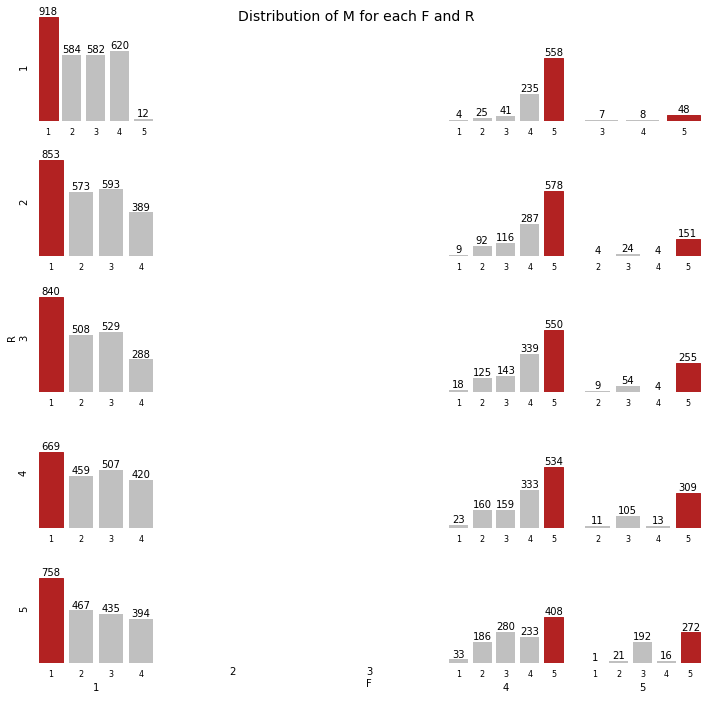

In [ ]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 13))

for i, p in enumerate(['R_score', 'F_score']):
    parameters = {'R_score':'Recency', 'F_score':'Frequency'}
    y = traditional_rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = traditional_rfm[(traditional_rfm['R_score'] == r) & (traditional_rfm['F_score'] == f)]['M_score'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

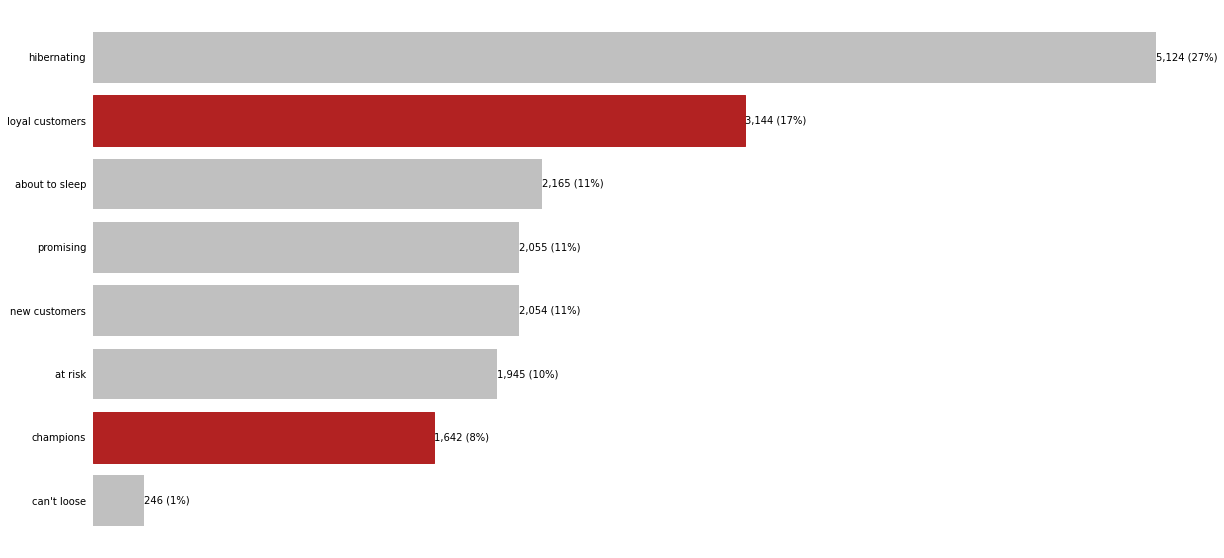

In [ ]:
# count the number of customers in each segment
segments_counts = traditional_rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()